*Contents*
===

- [Resampling](#Resampling)
    - [Exercise 2.1](#Exercise-2.1)
- [Rolling windows](#Rolling-windows)
    - [Exercise 2.2](#Exercise-2.2)

In the first lesson we have seen examples of data manipulation and visualization with Pandas, Matplotlib and Seaborn. We have used these tools to analise the seasonality of a time series.

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
sns.set()

In [36]:
df = pd.read_csv('../data/OPSD_Germany_all.csv',
                 parse_dates=True,
                 index_col='Date')

df['Weekday'] = df.index.day_name()

df.head()

,Consumption,Wind,Solar,Weekday
Date,,,,
2006-01-01,1069.184,NaN,NaN,Sunday
2006-01-02,1380.521,NaN,NaN,Monday
2006-01-03,1442.533,NaN,NaN,Tuesday
2006-01-04,1457.217,NaN,NaN,Wednesday
2006-01-05,1477.131,NaN,NaN,Thursday


Resampling
===

When we sample a time series with a frequency lower than the original, we are *downsampling*. To perform this operation we need an aggregation function.

Conversely, by increasing the sample frequency we are *upsampling*. What do we need in this case?

Downsampling is another effective tool for inspecting the seasonality of a time series. Let's start by computing the average weekly consumption of 2013.

In [37]:
df[['Consumption', 'Weekday']].loc['2013'].head(15)

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday


In [38]:
df[['Consumption', 'Weekday']].loc['2013'][:6]

,Consumption,Weekday
Date,,
2013-01-01,906.910,Tuesday
2013-01-02,1160.174,Wednesday
2013-01-03,1199.565,Thursday
2013-01-04,1198.952,Friday
2013-01-05,1108.271,Saturday
2013-01-06,1035.316,Sunday


In [39]:
df['Consumption']['2013'][:6].mean()

1101.5313333333331

In [40]:
df[['Consumption', 'Weekday']].loc['2013'][6:13]

,Consumption,Weekday
Date,,
2013-01-07,1364.084,Monday
2013-01-08,1397.750,Tuesday
2013-01-09,1408.435,Wednesday
2013-01-10,1388.447,Thursday
2013-01-11,1390.838,Friday
2013-01-12,1192.418,Saturday
2013-01-13,1112.380,Sunday


In [41]:
df['Consumption']['2013'][6:13].mean()

1322.0502857142856

We can compactly achieve the same result with *resample*. Pandas provides [shortcuts](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases) (*aliases*) for several resampling frequencies.

In [42]:
df['Consumption']['2013'].resample('W')

The function alone is not enough: we need an aggregation function.

In [43]:
df['Consumption']['2013'].resample('W').mean().head()

Date
2013-01-06    1101.531333
2013-01-13    1322.050286
2013-01-20    1388.535857
2013-01-27    1402.458000
2013-02-03    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

The *label* arguments allows to choose which endpoint (left or right) is assigned to the resampling window. 

In [44]:
df['Consumption']['2013'].resample('W', label='left').mean().head()

Date
2012-12-30    1101.531333
2013-01-06    1322.050286
2013-01-13    1388.535857
2013-01-20    1402.458000
2013-01-27    1319.079429
Freq: W-SUN, Name: Consumption, dtype: float64

By default, the right endpoint is included, while the left one is not. Such behaviour can be changed with the *closed* argument.

Let's build a new dataframe and plot it alongside with the original one.

In [45]:
df_consumption_2013_weekly = df['Consumption']['2013'].resample('W').mean()

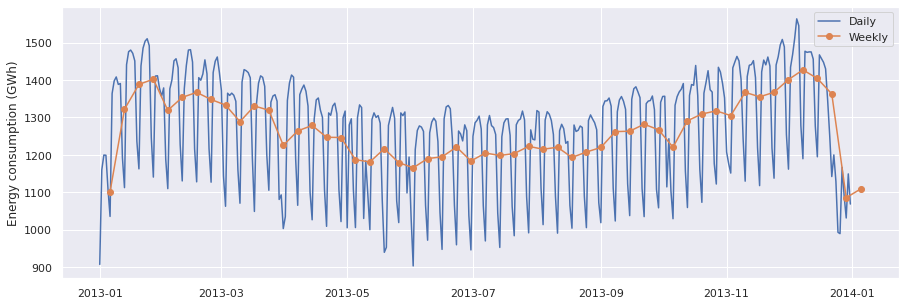

In [46]:
plt.figure(figsize=(15,5))

plt.plot(df['Consumption']['2013'], label='Daily')

plt.plot(df_consumption_2013_weekly,
         marker='o',
         label='Weekly')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

What effect have we gotten by weekly downsampling?

Exercise 2.1
---

Compare (within a single plot) the monthly series of
- electric energy consumption
- renewable energy production (solar, wind and the sum of the two).

Plot the yearly series of the ratio between
- renewable energy production
- electric energy consumption.

Rolling windows
===

The *rolling* function is another useful Pandas tool. Like with resample, an aggregation function is required.

Let's suppose we want to analyse energy consumption records within a three-day window.

In [47]:
df['Consumption']

Date
2006-01-01    1069.18400
2006-01-02    1380.52100
2006-01-03    1442.53300
2006-01-04    1457.21700
2006-01-05    1477.13100
                 ...    
2017-12-27    1263.94091
2017-12-28    1299.86398
2017-12-29    1295.08753
2017-12-30    1215.44897
2017-12-31    1107.11488
Name: Consumption, Length: 4383, dtype: float64

We sequentially shift the window from left to right: at the first two steps, the window will only contain respectively one and two values.

In [48]:
df['Consumption'][:1]

Date
2006-01-01    1069.184
Name: Consumption, dtype: float64

In [49]:
df['Consumption'][:2]

Date
2006-01-01    1069.184
2006-01-02    1380.521
Name: Consumption, dtype: float64

At this point, the window overlaps with the first three records.

In [50]:
df['Consumption'][:3]

Date
2006-01-01    1069.184
2006-01-02    1380.521
2006-01-03    1442.533
Name: Consumption, dtype: float64

And so on.

In [51]:
df['Consumption'][1:4]

Date
2006-01-02    1380.521
2006-01-03    1442.533
2006-01-04    1457.217
Name: Consumption, dtype: float64

In [52]:
df['Consumption'][2:5]

Date
2006-01-03    1442.533
2006-01-04    1457.217
2006-01-05    1477.131
Name: Consumption, dtype: float64

Let's now aggregate, at each step, all the records lying in the window. For example, we can sum them up.

In [53]:
df['Consumption'][:1].sum()

1069.1840000000002

In [54]:
df['Consumption'][:2].sum()

2449.705000000001

In [55]:
df['Consumption'][:3].sum()

3892.2380000000007

In [56]:
df['Consumption'][1:4].sum()

4280.271000000001

In [57]:
df['Consumption'][2:5].sum()

4376.881

Once the width of the sampling window and the aggregation function have been choosen, rolling allows to perform the above operation compactly.

In [58]:
df['Consumption'].rolling('3D').sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

The width of the window can be also specified through the number of records it should be containing at each step.

In [59]:
df['Consumption'].rolling(3).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Doing this, however, the window discards (by default) all the groups with at least one missing value. Of course, we can alter this behaviour by means of optional arguments.

In [60]:
df['Consumption'].rolling(3, min_periods=1).sum()

Date
2006-01-01    1069.18400
2006-01-02    2449.70500
2006-01-03    3892.23800
2006-01-04    4280.27100
2006-01-05    4376.88100
                 ...    
2017-12-27    3505.34112
2017-12-28    3693.92172
2017-12-29    3858.89242
2017-12-30    3810.40048
2017-12-31    3617.65138
Name: Consumption, Length: 4383, dtype: float64

Here are some more examples.

In [61]:
df['Consumption'].rolling(3, center=True).sum()

Date
2006-01-01           NaN
2006-01-02    3892.23800
2006-01-03    4280.27100
2006-01-04    4376.88100
2006-01-05    4337.77500
                 ...    
2017-12-27    3693.92172
2017-12-28    3858.89242
2017-12-29    3810.40048
2017-12-30    3617.65138
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

In [62]:
df['Consumption'][:7].sum()

9530.300000000001

In [63]:
df['Consumption'].rolling(7, center=True).sum()

Date
2006-01-01           NaN
2006-01-02           NaN
2006-01-03           NaN
2006-01-04    9530.30000
2006-01-05    9669.10100
                 ...    
2017-12-27    8457.49890
2017-12-28    8422.85648
2017-12-29           NaN
2017-12-30           NaN
2017-12-31           NaN
Name: Consumption, Length: 4383, dtype: float64

Let's now have a look at the graphical result yield by rolling. For the sake of convenience, we set the Matplotlib *figsize* property once and for all.

In [64]:
plt.rcParams['figure.figsize'] = (15,5)

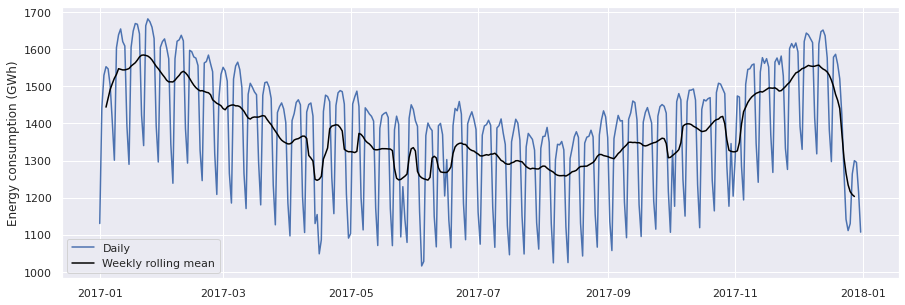

In [65]:
plt.plot(df['Consumption']['2017'],
         label='Daily')

plt.plot(df['Consumption']['2017'].rolling(7, center=True).mean(),
         label='Weekly rolling mean',
         color='black')

plt.ylabel('Energy consumption (GWh)')
plt.legend()

We have computed and represented the 2017 weekly *rolling mean* of our consumption data.

Exercise 2.2
---

Resample and rolling have common ground. How are their outcomes different?

Plot weekly solar energy production during 2017/01-07 by using resample and rolling. Compare the graphical results.

---

**Recap**: downsampling and rolling windows yield a smoothing effect on a time series. Specifically, variations happening at a frequency lower or equal to the width of the sampling window are canceled out.

Eliminating such seasonal variations allows to focus on another main component of a time series: its **trend**.

---

<script>
  $(document).ready(function(){
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('div.prompt').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter.
</footer>